In [15]:
import pandas as pd
import requests

# Get the data set
Gather the dataset and clean the column names and separate the columns with multiple data
For instance movie_country contains both the Freebase id and the country name, se we will split this information into 2 columns

In [36]:
# Get data set and format columns names
df_movie=pd.read_csv('../data/movie.metadata.tsv',sep='\t',header=None)
df_movie.columns=['wiki_movie_ID','freebase_movie_ID','movie_name','movie_release_date',\
    'movie_box_off_rev','movie_runtime','movie_languages','movie_countries','movie_genres']

# Separate dictionaries into 2 columns with Freebase id and value
df_movie["movie_countries_id"] = df_movie["movie_countries"].map(eval).apply(lambda x: list(x.keys()))
df_movie["movie_countries"] = df_movie["movie_countries"].map(eval).apply(lambda x: list(x.values()))
df_movie["movie_genres_id"] = df_movie["movie_genres"].map(eval).apply(lambda x: list(x.keys()))
df_movie["movie_genres"] = df_movie["movie_genres"].map(eval).apply(lambda x: list(x.values()))
df_movie["movie_languages_id"] = df_movie["movie_languages"].map(eval).apply(lambda x: list(x.keys()))
df_movie["movie_languages"] = df_movie["movie_languages"].map(eval).apply(lambda x: list(x.values()))
df_movie.head()


,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,movie_genres_id,movie_languages_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc]
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]",[/m/02h40lc]
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],"[/m/0lsxr, /m/07s9rl0]",[/m/05f_3]
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[/m/07ssc],"[/m/01jfsb, /m/0glj9q, /m/09blyk]",[/m/02h40lc]
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],[/m/07s9rl0],[/m/04306rv]


# Gather region for each country

For this we use an online API which provides various data bout each country, and will use the name given in the dataset to gather the corresponding region.

Since both data come from different source, it is highly probable that the country names don't match, so some completions and changes might need to be done.

In [37]:
# Get region for each country

region_lst = ["Africa", "Americas", "Asia", "Europe", "Oceania"]
countries = {"country" : [],
"region" : []}

country_lst = [[], []]
df_countries = pd.DataFrame(columns = ["country", "region"])

for region in region_lst:
    response = requests.get("https://restcountries.com/v3.1/region/" + region).json()

    for elem in response:
        countries["country"].append(elem.get("name").get("common"))
        countries["region"].append(region)

df_countries = pd.DataFrame.from_dict(countries)
df_countries.head()

,country,region
0,Mauritania,Africa
1,Niger,Africa
2,Togo,Africa
3,Madagascar,Africa
4,Algeria,Africa


## Missing countries in our country-region table

What are the unreferenced countries?

For each of these countries, how many movies did they produce/co-produce?

Which country reprensent 95% of all thoses movies (we keep these ones)

Update the country-region reference table

There is a total of 8053 movies that contain a null movie name (NaN) among the producing countries (movie_countries column)
98.869986% of them only contain 1 NaN occurence, up to 7962


1    7962
2      83
3       7
5       1
dtype: int64

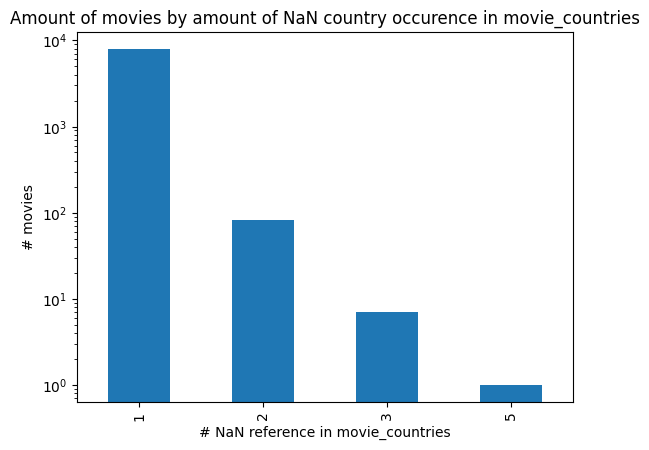

In [66]:
all_movie_countries = df_movie.explode("movie_countries", ignore_index = True)
unique_movie_countries = all_movie_countries.loc[all_movie_countries["movie_countries"].isnull()]
grunique_movie_countries = unique_movie_countries.groupby("movie_name").size()
grunique_movie_countries = grunique_movie_countries.groupby(grunique_movie_countries).size()
ax = grunique_movie_countries.plot.bar()
ax.set_yscale("log")
ax.set_xlabel("# NaN reference in movie_countries") 
ax.set_ylabel("# movies")
ax.set_title("Amount of movies by amount of NaN country occurence in movie_countries");
print(f"There is a total of {grunique_movie_countries.sum()} movies that contain a null movie name (NaN) among the producing countries (movie_countries column)")
print(f"{grunique_movie_countries.iloc[0]/grunique_movie_countries.sum() :%} of them only contain 1 NaN occurence, up to {grunique_movie_countries.max()}")
grunique_movie_countries


95% of these movies come from ['United States of America' 'West Germany']


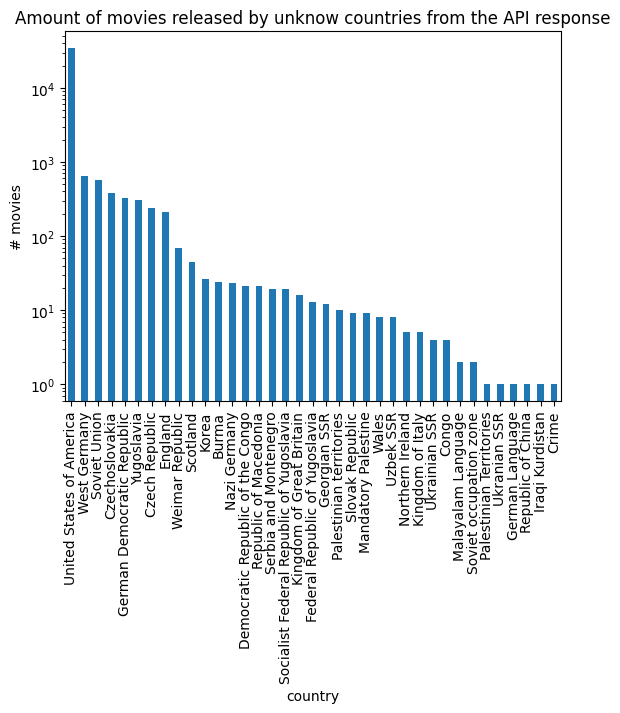

In [18]:
######################################
# What are the unreferenced countries?
######################################

# Get all unique countries in our dataset
all_movie_countries = df_movie["movie_countries"].explode(ignore_index = True)
unique_movie_countries = all_movie_countries.unique()

# Referenced unique countries
referenced_countries = df_countries["country"].unique()

# Unreferenced countries in the dataset
unreferenced = [a for a in unique_movie_countries if a not in referenced_countries]

###########################################################################
# For each of these countries, how many movies did they produce/co-produce?
###########################################################################

df_unreferenced = all_movie_countries.groupby(all_movie_countries).size()
df_unreferenced = df_unreferenced[df_unreferenced.index.isin(unreferenced)].sort_values(ascending = False)

# Plot
ax = df_unreferenced.plot.bar()
ax.set_yscale("log")
ax.set_xlabel("country") 
ax.set_ylabel("# movies")
ax.set_title("Amount of movies released by unknow countries from the API response");

# Get country names representing 95% of movie quantity
percentile_95 = df_unreferenced.sum() * 0.95
countries_to_keep = df_unreferenced[df_unreferenced.cumsum() <= percentile_95]

print(f"95% of these movies come from {countries_to_keep.index.values}")

# Add these countries to the API dataframe response
countries_to_add = dict(zip(["country", "region"], [countries_to_keep.index.values.tolist(), ["Americas", "Europe"]]))
countries_to_add = pd.DataFrame.from_dict(countries_to_add)
df_countries = pd.concat([df_countries, countries_to_add], ignore_index=True)


# Update the list of unreferenced countries
for country in countries_to_keep.index.values.tolist():
    unreferenced.pop(unreferenced.index(country))


## Clean dataset

Remove all movies with a movie_country item in one of the unreferenced country we do not consider

In [19]:
movie_count = len(df_movie)
df_movie = df_movie[df_movie.movie_countries.apply(lambda x: not any(i in unreferenced for i in x))]
print(f"{movie_count - len(df_movie)} movies were removed")

2282 movies were removed


## Add the region information to our dataset

*region* column contains the continent in which hte movie was produced (can be different regions if multiple countries from different continent co-produced)

In [20]:
# Add region column
# For each country in df_movie.movie_countries, get the region (remove region duplicates)
def get_region(country_lst):
    output = []
    for country in country_lst:
        try:
            output.append(df_countries.loc[df_countries["country"] == country]["region"].values[0])
        except:
            raise KeyError(f"{country} not found in the reference list")

    #remove duplicates
    return list(set(output))

df_movie["region"] = df_movie.loc[:, ("movie_countries")].apply(lambda x: get_region(x))
df_movie


,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,movie_genres_id,movie_languages_id,region
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc],[Americas]
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]",[/m/02h40lc],[Americas]
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],"[/m/0lsxr, /m/07s9rl0]",[/m/05f_3],[Europe]
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[/m/07ssc],"[/m/01jfsb, /m/0glj9q, /m/09blyk]",[/m/02h40lc],[Europe]
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],[/m/07s9rl0],[/m/04306rv],[Europe]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],[/m/09c7w0],[/m/07s9rl0],[/m/02h40lc],[Americas]
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]","[/m/03rt9, /m/07ssc]","[/m/03bxz7, /m/07s9rl0, /m/0jtdp]",[/m/02h40lc],[Europe]
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]",[/m/09c7w0],"[/m/06nbt, /m/01z4y]",[/m/02h40lc],[Americas]
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",[/m/03_3d],"[/m/06n90, /m/0gw5n2f, /m/03k9fj, /m/0hcr, /m/...",[/m/03_9r],[Asia]


# Movie repartition per region

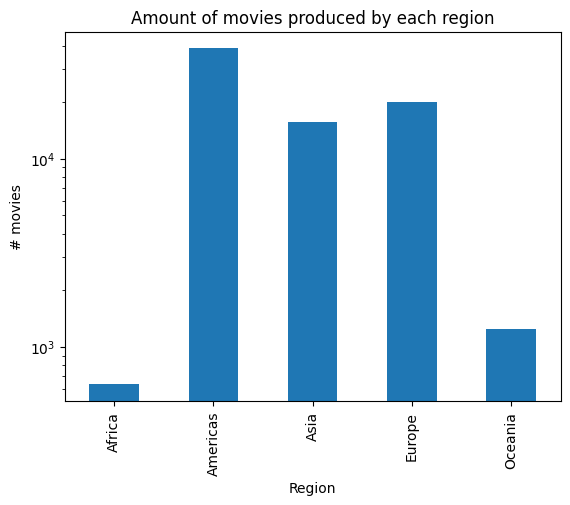

In [27]:
df_movie_region = df_movie["region"].explode()
df_movie_region = df_movie_region.groupby(df_movie_region).size()
ax = df_movie_region.plot.bar()
ax.set_yscale("log")
ax.set_xlabel("Region") 
ax.set_ylabel("# movies")
ax.set_title("Amount of movies produced by each region");